# FFT Performance on CPU vs GPU

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
import numpy as np
import matplotlib.pyplot as plt
import time

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.0a0+872d972e41.nv24.08
CUDA available: True
CUDA device: Orin


Image shape (1024, 1024)


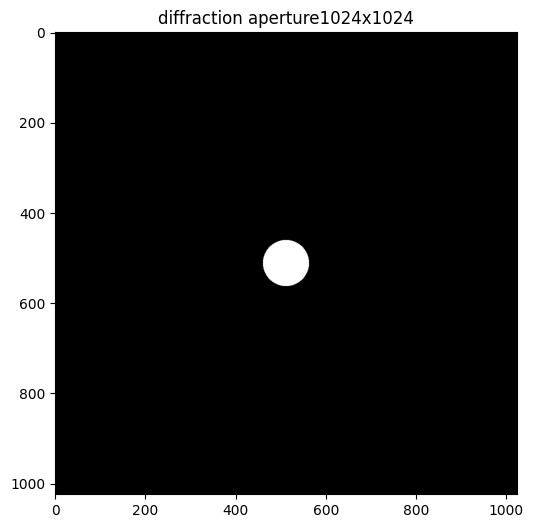

In [2]:
def generate_diffraction_aperture(size=512, aperture_radius_mm=0.5, plane_size_mm=10.0):
    L = plane_size_mm * 1e-3
    x = np.linspace(-L/2, L/2, size)
    X, Y = np.meshgrid(x, x)
    R = np.sqrt(X**2 + Y**2)
    aperture = (R <= aperture_radius_mm * 1e-3).astype(np.float32)
    return aperture

image_size = 1024
image_array = generate_diffraction_aperture(image_size, aperture_radius_mm=0.5)

print(f"Image shape {image_array.shape}")
plt.figure(figsize=(6, 6))
plt.imshow(image_array, cmap='gray')
plt.title(f"diffraction aperture{image_size}x{image_size}")
plt.show()

In [3]:
# convert to torch tensors
image_tensor = torch.from_numpy(image_array).float()
image_cpu = image_tensor.clone()
if torch.cuda.is_available():
    image_gpu = image_tensor.cuda()
    print("Created a GPU tensor")
else:
    print("CUDA not available, GPU skipped")
    image_gpu = None

Created a GPU tensor


In [4]:
def apply_fft_2d(image_tensor):
    fft_result = torch.fft.fft2(image_tensor)
    fft_shifted = torch.fft.fftshift(fft_result)
    magnitude_spectrum = torch.abs(fft_shifted) 
    return fft_shifted, magnitude_spectrum

def apply_inverse_fft_2d(fft_shifted): #inverse 2d FFT
    fft_result = torch.fft.ifftshift(fft_shifted)
    reconstructed = torch.fft.ifft2(fft_result)
    reconstructed_real = torch.real(reconstructed)
    return reconstructed_real

In [5]:
_ = apply_fft_2d(image_cpu)
# benchmarking values
num_iterations = 10
cpu_times = []
for i in range(num_iterations):
    start_time = time.time()
    fft_shifted_cpu, magnitude_cpu = apply_fft_2d(image_cpu)
    reconstructed_cpu = apply_inverse_fft_2d(fft_shifted_cpu)
    end_time = time.time()
    
    elapsed = (end_time - start_time) * 1000 
    cpu_times.append(elapsed)
    print(f"Iteration {i+1}/{num_iterations}, {elapsed:.2f} ms")

cpu_mean = np.mean(cpu_times)
cpu_std = np.std(cpu_times)

print(f"CPU performance:")
print(f"Average {cpu_mean:.2f} ms")

Iteration 1/10, 68.06 ms
Iteration 2/10, 71.16 ms
Iteration 3/10, 68.79 ms
Iteration 4/10, 75.70 ms
Iteration 5/10, 69.95 ms
Iteration 6/10, 71.97 ms
Iteration 7/10, 70.21 ms
Iteration 8/10, 73.99 ms
Iteration 9/10, 65.73 ms
Iteration 10/10, 66.14 ms
CPU performance:
Average 70.17 ms


In [6]:
if torch.cuda.is_available() and image_gpu is not None:
    # warmup
    _ = apply_fft_2d(image_gpu)
    torch.cuda.synchronize()
    # benchmark
    gpu_times = []
    
    for i in range(num_iterations):
        torch.cuda.synchronize()
        start_time = time.time()
        
        fft_shifted_gpu, magnitude_gpu = apply_fft_2d(image_gpu)
        reconstructed_gpu = apply_inverse_fft_2d(fft_shifted_gpu)
        
        torch.cuda.synchronize()
        end_time = time.time()
        
        elapsed = (end_time - start_time) * 1000 
        gpu_times.append(elapsed)
        print(f"Iteration {i+1}/{num_iterations}: {elapsed:.2f} ms")
    
    gpu_mean = np.mean(gpu_times)
    gpu_std = np.std(gpu_times)
    
    print(f"Gpu mean: {gpu_mean:.2f} ms")
    print(f"Gpu standard deviation: {gpu_std:.2f} ms")
    
    speedup = cpu_mean / gpu_mean
    print(f"Speedup: {speedup:.2f}x")
else:
    print("GPU unavailable, skipping gpu tests")
    gpu_times = None
    gpu_mean = None
    gpu_std = None

Iteration 1/10: 7.02 ms
Iteration 2/10: 6.91 ms


Iteration 3/10: 6.77 ms
Iteration 4/10: 7.06 ms
Iteration 5/10: 6.92 ms
Iteration 6/10: 6.92 ms
Iteration 7/10: 7.04 ms
Iteration 8/10: 6.93 ms
Iteration 9/10: 6.81 ms
Iteration 10/10: 6.63 ms
Gpu mean: 6.90 ms
Gpu standard deviation: 0.13 ms
Speedup: 10.17x


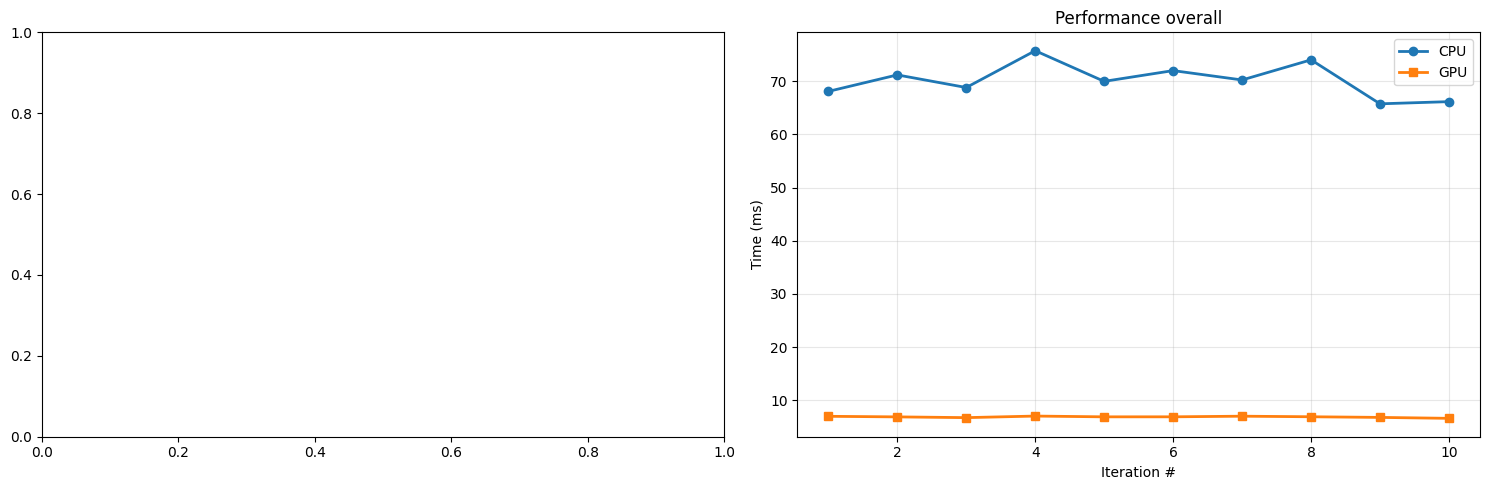

In [7]:
# Performance comparison plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
iterations = range(1, num_iterations + 1)
axes[1].plot(iterations, cpu_times, 'o-', label='CPU', linewidth=2, markersize=6)
if gpu_times is not None:
    axes[1].plot(iterations, gpu_times, 's-', label='GPU', linewidth=2, markersize=6)
axes[1].set_xlabel('Iteration #')
axes[1].set_ylabel('Time (ms)')
axes[1].set_title('Performance overall')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

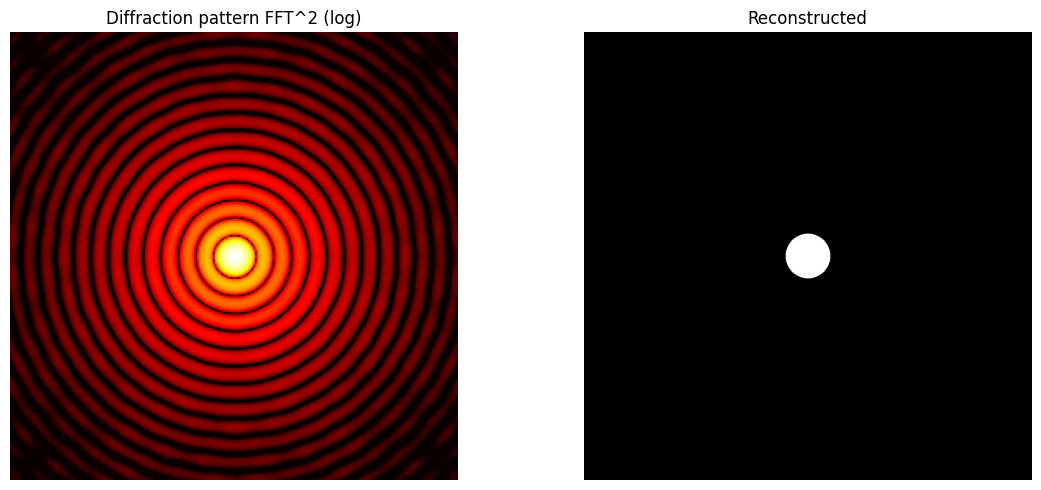

Reconstruction error MAE: 0.000000


In [8]:
intensity = (magnitude_cpu ** 2)
intensity = intensity / intensity.max()
center = image_size // 2
zoom = image_size // 8
intensity_zoomed = intensity[center-zoom:center+zoom, center-zoom:center+zoom]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(np.log10(intensity_zoomed.numpy() + 1e-10), cmap='hot', vmin=-5, vmax=0)
axes[0].set_title('Diffraction pattern FFT^2 (log)')
axes[0].axis('off')

axes[1].imshow(reconstructed_cpu.numpy(), cmap='gray')
axes[1].set_title('Reconstructed') # inverse fft
axes[1].axis('off')

plt.tight_layout()
plt.show()

reconstruction_error = torch.mean(torch.abs(image_cpu - reconstructed_cpu))
print(f"Reconstruction error MAE: {reconstruction_error:.6f}")

In [9]:
sizes = [256, 512, 1024, 2048, 4096]
cpu_results = []
gpu_results = []

for size in sizes:    
    test_img = generate_diffraction_aperture(size, aperture_radius_mm=0.5)
    test_tensor_cpu = torch.from_numpy(test_img).float()
    
    _ = apply_fft_2d(test_tensor_cpu)
    start = time.time()
    for _ in range(5):
        fft_result, _ = apply_fft_2d(test_tensor_cpu)
        _ = apply_inverse_fft_2d(fft_result)
    cpu_time = (time.time() - start) * 1000 / 5
    cpu_results.append(cpu_time)
    print(f"CPU: {cpu_time:.2f} ms")
    
    if torch.cuda.is_available():
        test_tensor_gpu = test_tensor_cpu.cuda()
        _ = apply_fft_2d(test_tensor_gpu)
        torch.cuda.synchronize()
        
        start = time.time()
        for _ in range(5):
            fft_result, _ = apply_fft_2d(test_tensor_gpu)
            _ = apply_inverse_fft_2d(fft_result)
        torch.cuda.synchronize()
        gpu_time = (time.time() - start) * 1000 / 5
        gpu_results.append(gpu_time)
        print(f"GPU: {gpu_time:.2f} ms")
        print(f"Speedup: {cpu_time/gpu_time:.2f}x")
    print()

CPU: 3.40 ms
GPU: 0.72 ms
Speedup: 4.75x

CPU: 13.37 ms
GPU: 1.75 ms
Speedup: 7.66x



CPU: 69.64 ms
GPU: 6.49 ms
Speedup: 10.74x

CPU: 320.32 ms
GPU: 17.38 ms
Speedup: 18.43x

CPU: 1355.71 ms
GPU: 99.76 ms
Speedup: 13.59x

